In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U keras-tuner


     |████████████████████████████████| 71kB 8.4MB/s 


In [3]:
# Import required packages, libraries and classes for the project

import numpy as np
np.random.seed(1)

import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
from keras.layers import InputLayer, ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.optimizers import Adam, SGD, Nadam
import keras
import kerastuner as kt
plt.style.use('default')

### Data Preprocessing

In [4]:
# Load the Dataset
df = pd.read_csv("/content/drive/My Drive/stockQFLS.csv",parse_dates = True,index_col=0)
df.head()

,Open,High,Low,Volume,SMA,EMA,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,STOCHD,Close
Date,,,,,,,,,,,,,,,
2014-06-15,18.357,18.434,18.136,931720.0,18.078095,18.172928,0.552,48.683736,-0.697586,-0.060299,18.06710,-1.514221e+06,62.222222,57.805213,18.221
2014-06-16,18.145,18.179,17.898,982840.0,18.084190,18.168121,0.314,45.079524,-1.895735,-0.072873,18.07095,-1.509559e+06,44.773663,62.716049,18.009
2014-06-17,17.847,18.417,17.847,1220000.0,18.100762,18.184033,0.204,49.158841,-1.333765,-0.066277,18.08795,-1.619076e+06,66.419753,72.522678,18.272
2014-06-18,18.272,18.680,18.264,668690.0,18.112524,18.175237,0.094,51.311048,-1.541096,-0.083672,18.09220,-1.904605e+06,76.954733,72.963405,18.400
2014-06-19,18.349,18.485,18.196,488820.0,18.126238,18.152760,0.068,48.757124,-0.322299,-0.117691,18.09815,-2.017427e+06,74.193548,64.516129,18.247


In [5]:
# Correlation Matrix
df.corr()['Close']

Open       0.998327
High       0.999250
Low        0.999016
Volume     0.108382
SMA        0.986210
EMA        0.989516
MOM        0.109056
RSI        0.163357
ROC        0.147149
MACD       0.223851
BB         0.986997
CHAIKIN    0.187980
STOCH      0.059589
STOCHD     0.061267
Close      1.000000
Name: Close, dtype: float64

In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Volume', 'SMA', 'EMA', 'MOM', 'RSI', 'ROC',
       'MACD', 'BB', 'CHAIKIN', 'STOCH', 'STOCHD', 'Close'],
      dtype='object')

In [7]:
# Extracting the features for the ConvLSTM model
series = df[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]]
print(series.shape)
series.head()

(1461, 8)


,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-15,18.221,0.552,48.683736,-0.697586,-0.060299,18.06710,-1.514221e+06,62.222222
2014-06-16,18.009,0.314,45.079524,-1.895735,-0.072873,18.07095,-1.509559e+06,44.773663
2014-06-17,18.272,0.204,49.158841,-1.333765,-0.066277,18.08795,-1.619076e+06,66.419753
2014-06-18,18.400,0.094,51.311048,-1.541096,-0.083672,18.09220,-1.904605e+06,76.954733
2014-06-19,18.247,0.068,48.757124,-0.322299,-0.117691,18.09815,-2.017427e+06,74.193548


In [8]:
# Normalisation
sc_X = StandardScaler()
series.iloc[:,1:] = sc_X.fit_transform(series.iloc[:,1:])
sc_y = StandardScaler()
series[['Close']] = sc_y.fit_transform(series[['Close']])
series

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-15,0.730724,0.729997,-0.168818,-0.148898,-0.244816,0.697941,-0.818081,0.276749
2014-06-16,0.672698,0.406700,-0.467349,-0.309258,-0.289363,0.699004,-0.814710,-0.287813
2014-06-17,0.744684,0.257277,-0.129466,-0.234044,-0.265996,0.703697,-0.893897,0.412563
2014-06-18,0.779719,0.107854,0.048798,-0.261793,-0.327622,0.704870,-1.100350,0.753431
2014-06-19,0.737841,0.072536,-0.162739,-0.098669,-0.448137,0.706513,-1.181926,0.664091
...,...,...,...,...,...,...,...,...
2020-05-03,0.144710,0.143172,-1.285596,-0.809563,-0.416153,0.174658,-0.394832,-0.072488
2020-05-04,0.117339,0.007333,-1.806088,-0.858576,-0.457685,0.188737,-0.545255,-0.996940
2020-05-05,0.128287,0.007333,-1.714210,-0.744942,-0.472662,0.203368,-0.622954,-0.981533


In [9]:
# Train/Test Data Split
train_start = dt.date(2014,5,15)
train_end = dt.date(2020,3,1)
train_data = series.loc[train_start:train_end]

test_start = dt.date(2020,3,2)
test_end = dt.date(2020,6,14)
test_data = series.loc[test_start:test_end]

print(train_data.shape,test_data.shape)

(1412, 8) (49, 8)


In [10]:
train = train_data.values
val = test_data.values

In [11]:
# Setting up an Early Stopping function
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]
RMSE = keras.metrics.RootMeanSquaredError()

In [12]:
X_train = []
Y_train = []
X_val = []
Y_val = []
timesteps = 45

# Loop for training data
for i in range(timesteps,train.shape[0]):
  X_train.append(train[i-timesteps:i])
  Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

# Loop for val data
for i in range(timesteps,val.shape[0]):
  X_val.append(val[i-timesteps:i])
  Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1, X_val.shape[2], 1)

In [13]:
from keras import backend as K
from keras.losses import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

In [14]:
def model_builder(hp):
  # Define the ConvLSTM Model
  model = Sequential()

  # Input shape: (samples, time, channels, rows, cols) see: https://keras.io/layers/recurrent/#convlstm2d
  hp_filter = hp.Choice('filter', values = [8,16,32])
  model.add(ConvLSTM2D(
          filters=hp_filter,
          kernel_size=(10, 10),
          input_shape=(X_train.shape[1], 1, X_train.shape[3], 1),
          padding='same',
          return_sequences=True))
  model.add(LeakyReLU())
  model.add(BatchNormalization())

  model.add(ConvLSTM2D(
          filters=hp_filter,
          kernel_size=(5, 5),
          padding='same',
          return_sequences=False))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  hp_dropout = hp.Float('dropout', min_value = .2, max_value = .5, step = .1)

  model.add(Dropout(rate = hp_dropout))

  model.add(Flatten())

  hp_units = hp.Int('units', min_value = 16, max_value = 64, step = 8)
  model.add(Dense(units=hp_units, kernel_initializer='TruncatedNormal'))
  model.add(LeakyReLU())
  model.add(Dropout(rate = hp_dropout))

  model.add(Dense(units=hp_units, kernel_initializer='TruncatedNormal'))
  model.add(LeakyReLU())
  model.add(Dropout(rate = hp_dropout))

  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  hp_batch = hp.Choice('batch_size', values = [8,16,64])

  model.compile(optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
                loss = root_mean_squared_error,
                metrics=[root_mean_squared_error,'mse', 'mae', 'mape'])
  
  return model

In [15]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 50,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [16]:
import tensorflow as tf
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [17]:
tuner.search(X_train, Y_train, epochs = 10, validation_data = (X_val, Y_val), callbacks = [ClearTrainingOutput()])


Trial 90 Complete [00h 17m 41s]
val_loss: 0.018980273976922035

Best val_loss So Far: 0.005545495077967644
Total elapsed time: 05h 20m 58s
INFO:tensorflow:Oracle triggered exit


In [18]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.\nThe optimal number of units in the first densely-connected layer is {best_hps.get('units')}\n
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}\n
The best dropout is {best_hps.get('dropout')}\n
The best batch size is {best_hps.get('batch_size')}\n
The best num of epochs is {best_hps.get('tuner/epochs')}\n
The best num of filters is {best_hps.get('filter')}.
""")


The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is 48

The optimal learning rate for the optimizer is 0.01

The best dropout is 0.4000000000000001

The best batch size is 8

The best num of epochs is 6

The best num of filters is 32.



In [19]:
tuner.results_summary(num_trials=90)

Results summary
Results in my_dir/intro_to_kt
Showing 90 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filter: 32
dropout: 0.4000000000000001
units: 48
learning_rate: 0.01
batch_size: 8
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.005545495077967644
Trial summary
Hyperparameters:
filter: 8
dropout: 0.2
units: 24
learning_rate: 0.0001
batch_size: 64
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.006151767447590828
Trial summary
Hyperparameters:
filter: 16
dropout: 0.30000000000000004
units: 24
learning_rate: 0.01
batch_size: 64
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.00906267948448658
Trial summary
Hyperparameters:
filter: 8
dropout: 0.30000000000000004
units: 64
learning_rate: 0.001
batch_size: 16
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.009665684774518013
Trial summary
Hyperparameters:
filter: 16


In [20]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, Y_train, epochs = 50, validation_data = (X_val, Y_val))

Epoch 1/50
43/43 [==============================] - 26s 510ms/step - loss: 0.7039 - root_mean_squared_error: 0.7039 - mse: 0.8949 - mae: 0.7039 - mape: 147.9119 - val_loss: 0.4051 - val_root_mean_squared_error: 0.4051 - val_mse: 0.1649 - val_mae: 0.4051 - val_mape: 348.9898
Epoch 2/50
43/43 [==============================] - 21s 496ms/step - loss: 0.3834 - root_mean_squared_error: 0.3834 - mse: 0.2666 - mae: 0.3834 - mape: 95.4966 - val_loss: 0.3491 - val_root_mean_squared_error: 0.3491 - val_mse: 0.1291 - val_mae: 0.3491 - val_mape: 304.0124
Epoch 3/50
43/43 [==============================] - 21s 499ms/step - loss: 0.2791 - root_mean_squared_error: 0.2791 - mse: 0.1511 - mae: 0.2791 - mape: 58.6941 - val_loss: 0.3748 - val_root_mean_squared_error: 0.3748 - val_mse: 0.1408 - val_mae: 0.3748 - val_mape: 322.9395
Epoch 4/50
43/43 [==============================] - 21s 496ms/step - loss: 0.3338 - root_mean_squared_error: 0.3338 - mse: 0.2091 - mae: 0.3338 - mape: 115.7297 - val_loss: 0.09

In [21]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.title('Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [22]:
# Plotting the training errors
def plot_loss(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [23]:
# Evaluating the model
def evaluate_model(model,X_val):
     # Prediction Time 
    Y_hat = model.predict(X_val)
    return Y_val, Y_hat
  

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 45, 1, 8, 32)      422528    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 45, 1, 8, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 1, 8, 32)      128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 8, 32)          204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 8, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 8, 32)          128       
_________________________________________________________________
dropout (Dropout)            (None, 1, 8, 32)          0

In [25]:
y_pred = model.predict(X_val)
y_true = np.array([Y_val]).T

mae = tf.keras.losses.MeanAbsoluteError()
mae = mae(y_true, y_pred).numpy()

mape = tf.keras.losses.MeanAbsolutePercentageError()
mape = mape(y_true, y_pred).numpy()

mse = tf.keras.losses.MeanSquaredError()
mse = mse(y_true, y_pred).numpy()

rmse = sqrt(mse)


In [26]:
print('MSE = {}'.format(round(mse, 5)))
print('RMSE = {}'.format(round(rmse, 5)))
print('MAPE = {}'.format(round(mape, 5)))
print('MAE = {}'.format(round(mae, 5)))

MSE = 0.16259999573230743
RMSE = 0.4033
MAPE = 341.2972106933594
MAE = 0.399399995803833


In [27]:
true ,predicted = evaluate_model(model,X_val)

In [28]:
train_date = df['2014-05-15' : '2020-03-1'].index
test_date = df['2020-03-2' :].index
pred_date = df['2020-03-2' :].index[45:]

In [29]:
Y_train = sc_y.inverse_transform(np.array([train[:,0]]))
Y_test = sc_y.inverse_transform(np.array([val[:,0]]))
Y_pred = sc_y.inverse_transform(predicted.T)

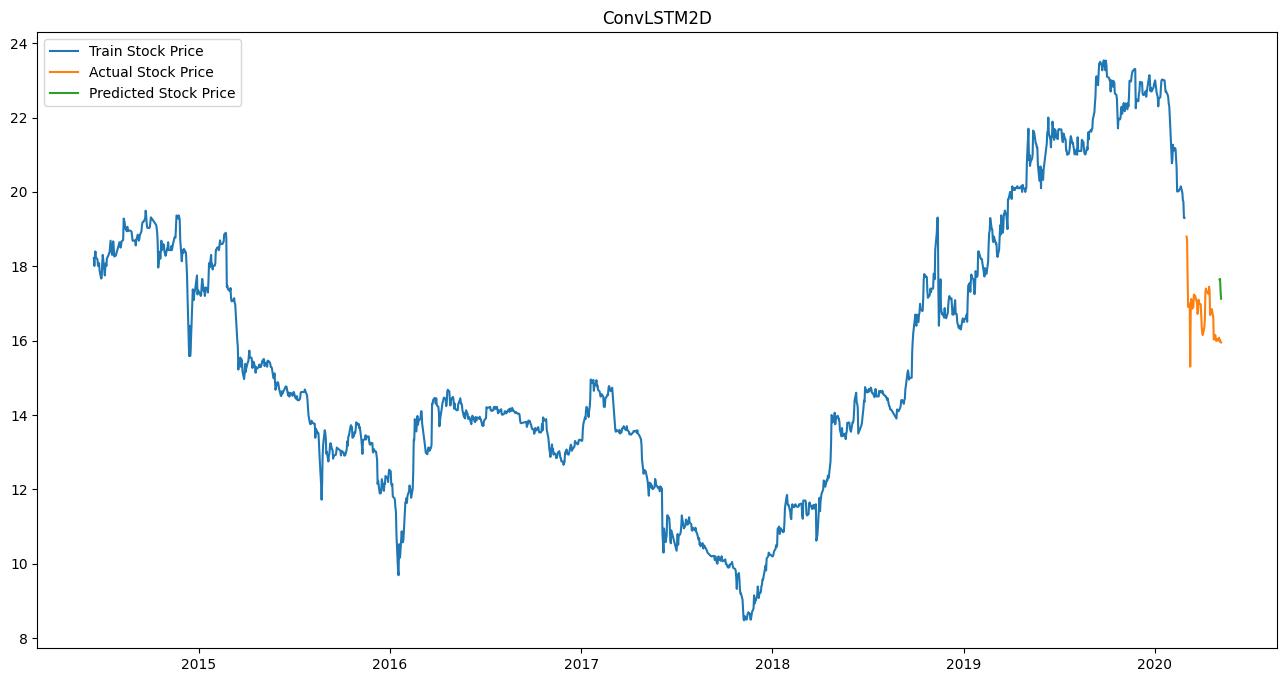

In [30]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.figure(figsize=(16,8))
price_close_train = Y_train[0]
price_close_test = Y_test[0]
plt.plot(train_date, price_close_train, label = "Train Stock Price")
plt.plot(test_date, price_close_test, label = "Actual Stock Price")
plt.plot(pred_date, Y_pred[0], label = "Predicted Stock Price")

plt.title("ConvLSTM2D")
plt.legend(loc='upper left')
#plt.tight_layout()

plt.show()

In [31]:
# Save a model
model.save('ConvLSTM2D_dataset2.h5')